# Introduction

The dataset that we have chosen is happiness 2017, 2018, and, 2019 dataset, one of Kaggle’s dataset. This dataset gives the happiness rank and happiness score of 155 countries around the world based on seven factors including family, life expectancy, economy, generosity, trust in government, freedom, and dystopia residual. Sum of the value of these seven factors gives us the happiness score and the higher the happiness score, the lower the happiness rank. So, it is evident that the higher value of each of these seven factors means the level of happiness is higher. We can define the meaning of these factors as the extent to which these factors lead to happiness. Dystopia is the opposite of utopia and has the lowest happiness level. Dystopia will be considered as a reference for other countries to show how far they are from being the poorest country regarding happiness level.

There are three parts to my report as follows:

*Cleaning
*Visualization
*Prediction

# Mission

The purpose of choosing this work is to find out which factors are more important to live a happier life. As a result, people and countries can focus on the more significant factors to achieve a higher happiness level. We also will implement several machine learning algorithms to predict the happiness score and compare the result to discover which algorithm works better for this specific dataset.

In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
from discover_feature_relationships import discover
import sklearn
import holoviews as hv
import hvplot.pandas
import matplotlib.pyplot as plt
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from sklearn.decomposition import MiniBatchSparsePCA as PCA
%matplotlib inline

# Cleaning

In [2]:
df_2017 = pd.read_csv("Happiness_rate_global/2017.csv")
df_2018 = pd.read_csv("Happiness_rate_global/2018.csv")
df_2019 = pd.read_csv("Happiness_rate_global/2019.csv")

In [3]:
df_2017.head()

,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [4]:
df_2018.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.632,1.305,1.592,0.874,0.681,0.202,0.393
1,2,Norway,7.594,1.456,1.582,0.861,0.686,0.286,0.340
2,3,Denmark,7.555,1.351,1.590,0.868,0.683,0.284,0.408
3,4,Iceland,7.495,1.343,1.644,0.914,0.677,0.353,0.138
4,5,Switzerland,7.487,1.420,1.549,0.927,0.660,0.256,0.357


In [5]:
df_2019.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


Let's construct a Dataframe that contains the actual features.
Since the data from the years have a bit of a different naming convention, so I'll abstract these to a common name.

In [6]:
targets = ['Low', 'Low-Mid', 'Top-Mid', 'Top']
kw_cols = ['Country', 'GDP', 'Family', 'Social', 'Life', 'Healthy', 'Freedom', 'Generosity', 'Trust', 'Perceptions']
h_cols = ['Country', 'GDP per capita', 'Family Support', 'Life Expectancy', 'Freedom', 'Generosity', 'Trust in Gov']
def prep_frame(df_year, year):
    df = pd.DataFrame()
    # Work around to load 2015, 2016, 2017 data into one common column
    target_cols = []
    for c in kw_cols:
        target_cols.extend([x for x in df_year.columns if c in x])
    df[h_cols] = df_year[target_cols]
    df['Happiness Score'] = df_year[[x for x in df_year.columns if 'Score' in x]]
    if not df['Happiness Score'].size == 155:
        df = df.iloc[:-1]
    # Calculate quartiles on the data.
    df["target"] = pd.qcut(df[df.columns[-1]], len(targets), labels=targets)
    df["target_n"] = pd.qcut(df[df.columns[-2]], len(targets), labels=range(len(targets)))
    # Append year and assign to multi-index
    df['Year'] = year
    df = df.set_index(['Country', 'Year'])
    return df
df = prep_frame(df_2017, 2017)
df = df.append(prep_frame(df_2018, 2018), sort=False)
df = df.append(prep_frame(df_2019, 2019), sort=False)
df.head()

,,GDP per capita,Family Support,Life Expectancy,Freedom,Generosity,Trust in Gov,Happiness Score,target,target_n
Country,Year,,,,,,,,,
Norway,2017,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,7.537,Top,3
Denmark,2017,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,7.522,Top,3
Iceland,2017,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,7.504,Top,3
Switzerland,2017,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,7.494,Top,3
Finland,2017,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,7.469,Top,3


In [32]:
cormatrix= df.corr(method='spearman')
cormatrix

,GDP per capita,Family Support,Life Expectancy,Freedom,Generosity,Trust in Gov,Happiness Score
GDP per capita,1.000000,0.715888,0.788617,0.352962,0.004215,0.232790,0.812160
Family Support,0.715888,1.000000,0.666798,0.442624,0.027814,0.147550,0.785665
Life Expectancy,0.788617,0.666798,1.000000,0.318932,-0.029421,0.156585,0.768213
Freedom,0.352962,0.442624,0.318932,1.000000,0.305991,0.427645,0.526234
Generosity,0.004215,0.027814,-0.029421,0.305991,1.000000,0.276303,0.099056
Trust in Gov,0.232790,0.147550,0.156585,0.427645,0.276303,1.000000,0.255078
Happiness Score,0.812160,0.785665,0.768213,0.526234,0.099056,0.255078,1.000000


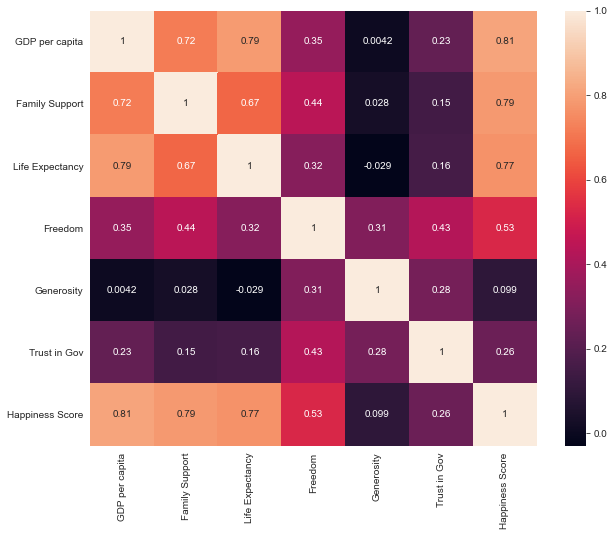

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(cormatrix, annot=True);

Looking at a pairwise comparison of our variables. The color is based on quartiles of the Happiness Score... 

[ 'Low','Low-Mid','Top-Mid', 'Top'] == [0%-25%, 25%-50%, 50%-75%, 75%-100%].

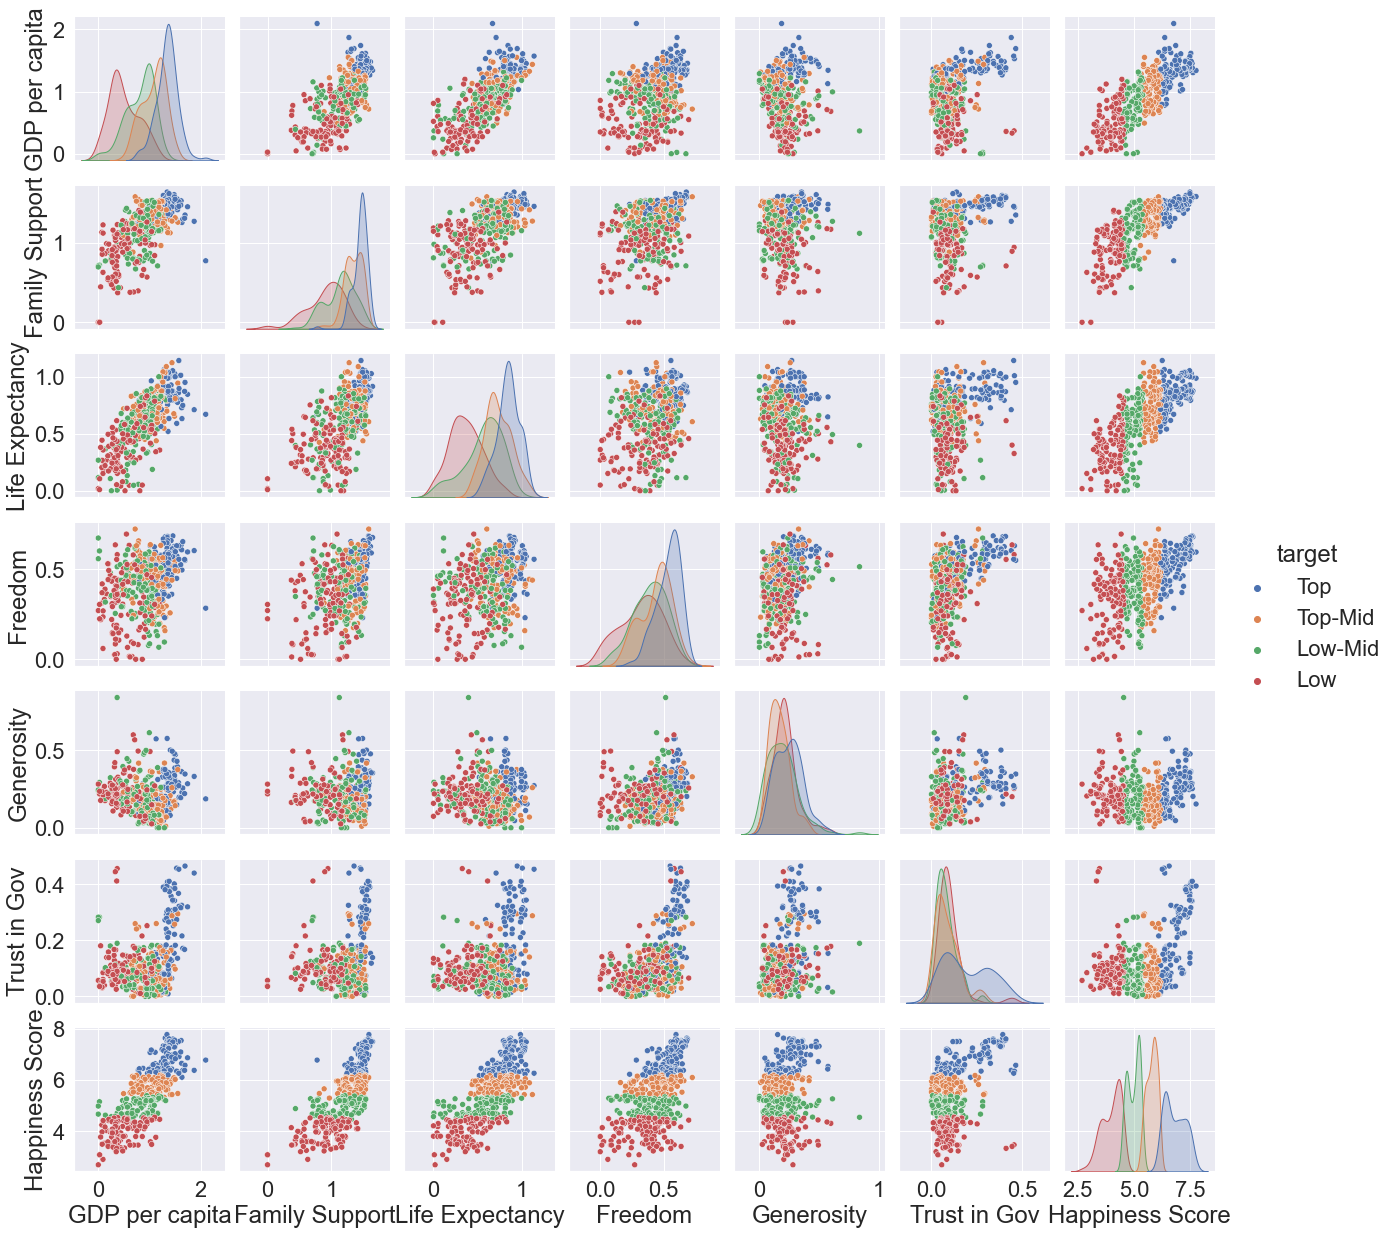

In [183]:
sns.set(font_scale=2)
sns.pairplot(df.drop(['target_n'], axis=1), hue='target',
             hue_order=['Top', 'Top-Mid' ,  'Low-Mid', 'Low']);

In [244]:
sns.set(font_scale=1)

The next step is adding another column to the dataset which is continent. I want to work on different continents to discover whether there are different trends for them regarding which factors play a significant role in gaining higher happiness score. Asia, Africa, North America, South America, Europe, and Australia are our six continents in this dataset. We can see the final structure of our dataset which consisted of 155 observations and 10 variables.

EU: European Union,    
NA: North America,    
SA: South America,       
AS: Asia',    
OC: Australia,    
AF: Africa,   

In [8]:
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_continent)

In [9]:
continent = []
for i in range(df.index.size):
    continent.append(get_continent(df.index[i][0]))
df['Continent'] = continent

In [10]:
df = df[['GDP per capita', 'Family Support', 'Life Expectancy', 'Freedom',
       'Generosity', 'Trust in Gov', 'Happiness Score', 'Continent', 'target', 'target_n',
       ]]

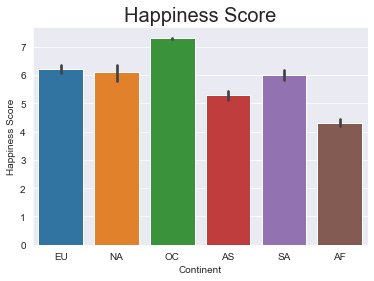

In [179]:
sns.set_style('darkgrid')
sns.barplot(x='Continent', y='Happiness Score',
            data=df[df['Continent'] != 'Unknown']).set_title('Happiness Score', fontdict={'fontsize':20});

In [180]:
n_rows = 2
n_cols = 3
df_data = df[df['Continent'] != 'Unknown']
target_cols = ['GDP per capita', 'Family Support', 'Life Expectancy',
               'Freedom', 'Generosity', 'Trust in Gov']

def plot_each_cols(n_row, n_col, data, cols):
    fig, axes = plt.subplots(n_row, n_col, figsize=(18,10), sharex=True)
    row_index = 0
    col_index = 0
    for c in range(len(target_cols)):
        sns.barplot(ax=axes[row_index][col_index], x='Continent', y=target_cols[c], data=data).set_title(target_cols[c],
                                                                             fontdict={'fontsize':20})
        col_index += 1
        if c == (n_cols-1):
            col_index = 0
            row_index += 1

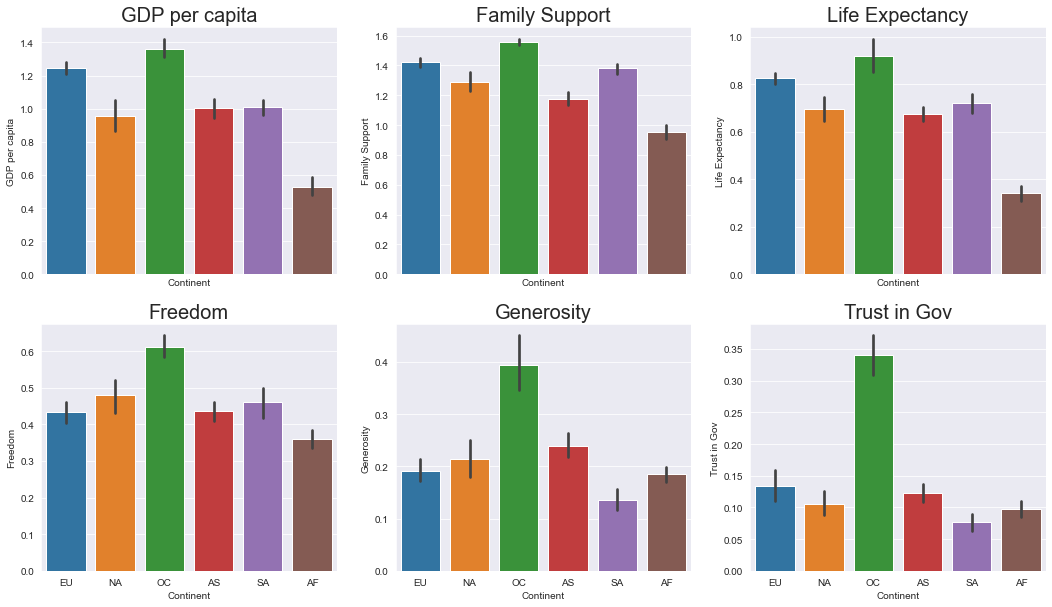

In [181]:
plot_each_cols(n_rows, n_cols, df_data, target_cols)

Australia has apporoximately the highest average in all fields. after that Europe, North America, South America, and Asia are roughly the same regarding happiness score and the other six factors. Finally, Africa have the lowest scores in all fields.

# Correlation plot for each continent

EU

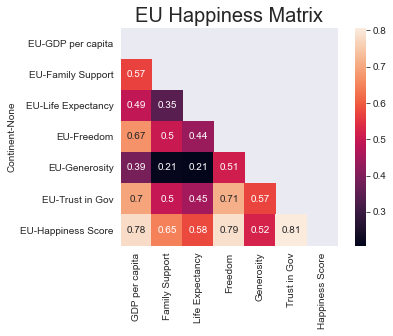

In [26]:
AF_corr = df[df['Continent'] == 'EU'].groupby('Continent').corr()
mask = np.zeros_like(AF_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(AF_corr, mask=mask, annot=True, square=True)
plt.title('EU Happiness Matrix', fontdict={'fontsize': 20});

 Trust in Gov > Freedom > GDP per capita > Family Support > Life Expectancy > Generosity 
 
 Trust in Gov, Freedom, and GDP per capita are highly correlated with happiness Score. It seems like a lot of civilian has distrusted or doubted their own goverment lay a political conspiracy.

North America

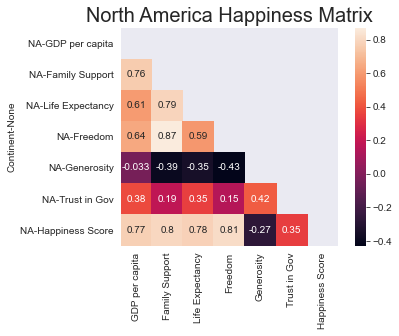

In [27]:
AF_corr = df[df['Continent'] == 'NA'].groupby('Continent').corr()
mask = np.zeros_like(AF_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(AF_corr, mask=mask, annot=True, square=True)
plt.title('North America Happiness Matrix', fontdict={'fontsize': 20});

 Freedom > Life Expectancy > GDP per capita > Trust in Gov > Family Support > Generosity
 
 Freedom, Life Expectancy, GDP per capita, are highly correlated with happiness score. Surprisingly there is an inverse correlation between score and Generosity

South America

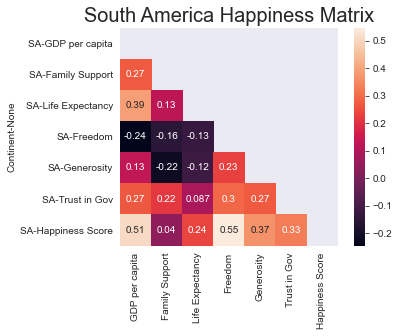

In [28]:
AF_corr = df[df['Continent'] == 'SA'].groupby('Continent').corr()
mask = np.zeros_like(AF_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(AF_corr, mask=mask, annot=True, square=True)
plt.title('South America Happiness Matrix', fontdict={'fontsize': 20});

Freedom > GDP per capita > Generosity > Trust in Gov > Life Expectancy > Family Support    
Freedom, GDP per capita are modestly correlated with Happiness Score

Asia

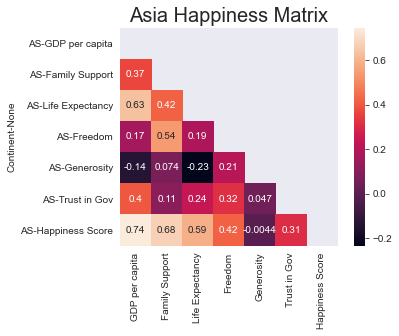

In [29]:
AF_corr = df[df['Continent'] == 'AS'].groupby('Continent').corr()
mask = np.zeros_like(AF_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(AF_corr, mask=mask, annot=True, square=True)
plt.title('Asia Happiness Matrix', fontdict={'fontsize': 20});

GDP per capita >  Family Support > Life Expectancy > Freedom > Trust in Gov > Generosity    

GDP per capita, Family Support are correlated with Happiness Score. There is alomost a no correlation between Score and Generosity 

Australia

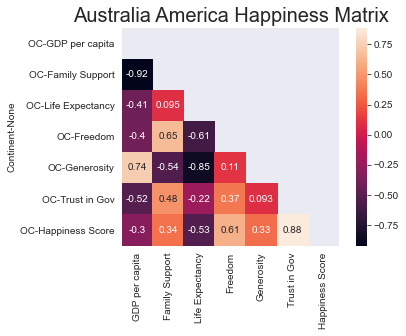

In [30]:
AF_corr = df[df['Continent'] == 'OC'].groupby('Continent').corr()
mask = np.zeros_like(AF_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(AF_corr, mask=mask, annot=True, square=True)
plt.title('Australia America Happiness Matrix', fontdict={'fontsize': 20});

 Trust in Gov > Freedom > Family Support > Generosity > GDP per capita > Life Expectancy     
 
 Trust in Gov is highly correlated with Happiness Score. Unconventilonally Austaraila has a no correlation between Score and GDP per capita even though Austraila has apporoximately the highest Happiness Score. This is really interesting found. 

Africa

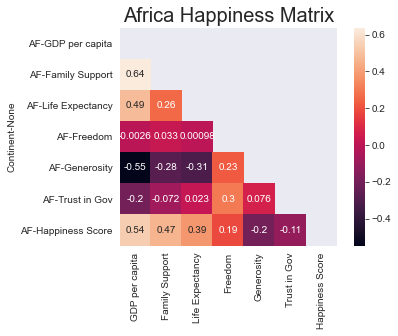

In [31]:
AF_corr = df[df['Continent'] == 'AF'].groupby('Continent').corr()
mask = np.zeros_like(AF_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(AF_corr, mask=mask, annot=True, square=True)
plt.title('Africa Happiness Matrix', fontdict={'fontsize': 20});

GDP per capita > Family Support  > Life Expectancy > Freedom > Generosity > Trust in Gov    

GDP per capita, Family Support, Life Expectancy are modestly correlated with Hapiness Score.

# Summary  

#EU : Trust in Gov > Freedom > GDP per capita        

#North America : Freedom > Life Expectancy > GDP per capita       

#South America: Freedom > GDP per capita > Generosity

#Asia: GDP per capita > Family Support> Life Expectancy      

#Australia: Trust in Gov > Freedom > Family Support    

#Africa: GDP per capita > Family Support > Life Expectancy     

GDP per capita,  Freedom , Family Support, are most highly correlated with Hapiness Score thorough the continents. However each factors are having slightly diffrent weights depends on diffrent continents. thus It seems like deciding what the factors are most important for Happiness Score by separating the continents is not so good idea to precisely detetmine the factors. On the other hand it can be used for a good reference determining the factor.

 A high focus on GDP and strongly correlated features such as family and life expectancy.

It goes well with common wisdom that money makes you happy up to a certain threshold. Having a good social net is important and family tends to provide that. High life expectancy and health make you worry less about how you'll survive.

# Ploting distribution on each diffrent continents

We will use scatter plot, box plot, and violin plot to see the happiness score distribution in different countries, how this score is populated in these continents and also will calculate the mean and median of happiness score for each of these continents.



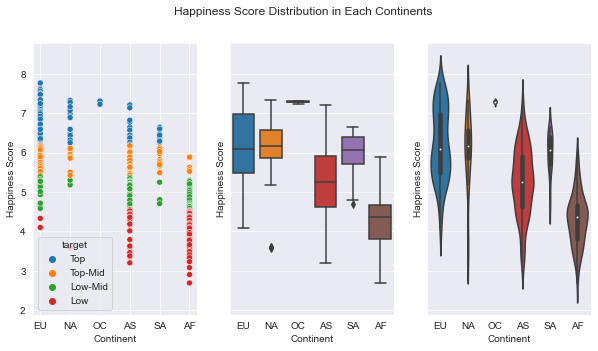

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
fig.suptitle('Happiness Score Distribution in Each Continents')

sns.scatterplot(ax=axes[0], x='Continent', y='Happiness Score', data=df[df['Continent'] != 'Unknown'],
                hue='target', hue_order=['Top', 'Top-Mid' ,  'Low-Mid', 'Low'])

sns.boxplot(ax=axes[1], x='Continent', y='Happiness Score', data=df[df['Continent'] != 'Unknown'])

sns.violinplot(ax=axes[2], x='Continent', y='Happiness Score', data=df[df['Continent'] != 'Unknown'],
               scale='count');

In [114]:
happiness_score_mean_median = pd.concat((df.groupby('Continent').mean()[['Happiness Score']],
                                       df.groupby('Continent').median()[['Happiness Score']],),
                                       axis=1)
happiness_score_mean_median.columns = ['Mean', 'Median']
happiness_score_mean_median.iloc[:-1].sort_values(by='Median', ascending=False)

,Mean,Median
Continent,,
OC,7.288167,7.2955
NA,6.085692,6.1680
EU,6.206530,6.0980
SA,5.999500,6.0570
AS,5.279519,5.2610
AF,4.315840,4.3740


As we have seen before, Australia has the highest median happiness score. Europe, South America, and North America are in the second place regarding median happiness score. Asia has the lowest median after Africa. We can see the range of happiness score for different continents, and also the concentration of happiness score.



In [207]:
pca = PCA(n_components=2,
          batch_size=10,
          normalize_components=True,
          random_state=42)
principalComponents = pca.fit_transform(df[h_cols[1:]])

source = df.copy()
source['component 1'] = principalComponents[:,0]
source['component 2'] = principalComponents[:,1]

/Users/hiroki.shimizu/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_sparse_pca.py:21: FutureWarning: 'normalize_components' has been deprecated in 0.22 and will be removed in 0.24. Remove the parameter from the  constructor.
  warnings.warn(


In [208]:
source.head()

,,GDP per capita,Family Support,Life Expectancy,Freedom,Generosity,Trust in Gov,Happiness Score,Continent,target,target_n,component 1,component 2
Country,Year,,,,,,,,,,,,
Norway,2017,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,7.537,EU,Top,3,0.685827,0.340159
Denmark,2017,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,7.522,EU,Top,3,0.565121,0.356718
Iceland,2017,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,7.504,EU,Top,3,0.581618,0.415463
Switzerland,2017,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,7.494,EU,Top,3,0.667238,0.322467
Finland,2017,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,7.469,EU,Top,3,0.538010,0.345306


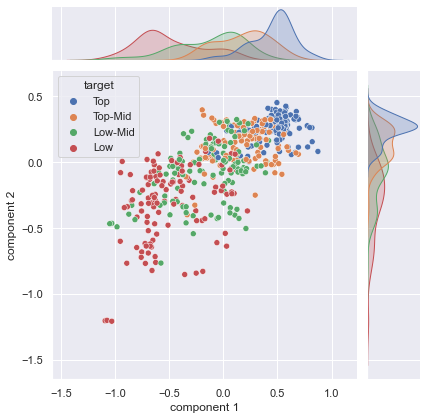

In [246]:
sns.jointplot(data=source, x='component 1', y='component 2', kind='scatter', hue='target',
             hue_order=['Top', 'Top-Mid' ,  'Low-Mid', 'Low']);

# Prediction 

In [396]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [272]:
t_df = df.drop(['Continent', 'target','target_n'], axis=1).copy()
t_df.head()

,,GDP per capita,Family Support,Life Expectancy,Freedom,Generosity,Trust in Gov,Happiness Score
Country,Year,,,,,,,
Norway,2017,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,7.537
Denmark,2017,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,7.522
Iceland,2017,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,7.504
Switzerland,2017,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,7.494
Finland,2017,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,7.469


In [273]:
t_df.to_pickle('shimi_t_df.pkl')
t_df = pd.read_pickle('shimi_t_df.pkl')

In [271]:
X = t_df.drop('Happiness Score', axis=1).values
y = t_df['Happiness Score'].values

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Simple LinearRegression

In [397]:
lin_reg = LinearRegression()

In [398]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [399]:
lin_prediction = lin_reg.predict(X_test)

In [401]:
lin_reg.score(X_test, y_test)

0.7089900864536396

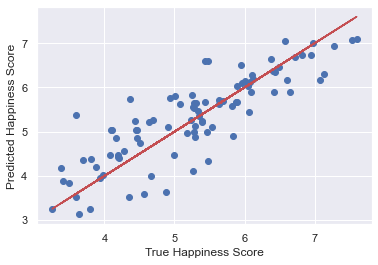

In [400]:
plt.xlabel('True Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.scatter(y_test, lin_prediction)
plt.plot(y_test, y_test, c='r');

Comparing Support Vector Regressor and Simple Neural Network for implementing a prediction model that hapiness Score as depending variable. So Let's tackle with SVR at first!

In [350]:
svr = SVR()

In [363]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100]
Gammas = [0.001, 0.01, 0.1, 1, 10, 100]
reg = GridSearchCV(svr, param_grid=dict(C=Cs, gamma=Gammas),n_jobs=-1, cv=5)

In [364]:
reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [365]:
reg.best_params_

{'C': 10, 'gamma': 1}

In [366]:
svr_prediction = reg.predict(X_test)

In [367]:
mae = mean_absolute_error(y_test, svr_prediction)
mse = mean_squared_error(y_test, svr_prediction)
rmse = np.sqrt(mse)

In [368]:
print('mean_absolute_error: ', mae)
print('mean_squared_error: ', mse)
print('root_mean_squared_error: ', rmse)

mean_absolute_error:  0.42702177334400954
mean_squared_error:  0.29897569726487405
root_mean_squared_error:  0.5467867017995902


In [355]:
y.mean()

5.38683405203655

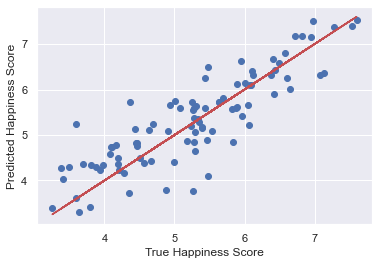

In [370]:
plt.xlabel('True Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.scatter(y_test, svr_prediction)
plt.plot(y_test, y_test, c='r');

In [369]:
reg.score(X_test, y_test)

0.7308076626378879

# DNN

In [383]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [374]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [375]:
X_train_scaled.shape

(371, 6)

In [428]:
model = Sequential()

model.add(BatchNormalization(input_shape=[6,]))
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [429]:
history = model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test))

Epoch 1/400
12/12 [==============================] - 0s 24ms/step - loss: 32.0644 - val_loss: 29.9278
Epoch 2/400
12/12 [==============================] - 0s 7ms/step - loss: 31.4141 - val_loss: 29.2520
Epoch 3/400
12/12 [==============================] - 0s 8ms/step - loss: 30.8324 - val_loss: 28.7335
Epoch 4/400
12/12 [==============================] - 0s 11ms/step - loss: 30.3164 - val_loss: 28.2909
Epoch 5/400
12/12 [==============================] - 0s 6ms/step - loss: 29.8946 - val_loss: 27.9195
Epoch 6/400
12/12 [==============================] - 0s 7ms/step - loss: 29.4891 - val_loss: 27.5717
Epoch 7/400
12/12 [==============================] - 0s 12ms/step - loss: 29.0380 - val_loss: 27.2535
Epoch 8/400
12/12 [==============================] - 0s 6ms/step - loss: 28.2693 - val_loss: 26.8930
Epoch 9/400
12/12 [==============================] - 0s 10ms/step - loss: 27.9070 - val_loss: 26.4499
Epoch 10/400
12/12 [==============================] - 0s 6ms/step - loss: 27.5143 - val

12/12 [==============================] - 0s 4ms/step - loss: 5.8505 - val_loss: 1.6700
Epoch 83/400
12/12 [==============================] - 0s 4ms/step - loss: 5.3363 - val_loss: 1.6661
Epoch 84/400
12/12 [==============================] - 0s 4ms/step - loss: 5.1966 - val_loss: 1.7335
Epoch 85/400
12/12 [==============================] - 0s 4ms/step - loss: 5.1144 - val_loss: 1.6041
Epoch 86/400
12/12 [==============================] - 0s 4ms/step - loss: 5.7890 - val_loss: 1.5840
Epoch 87/400
12/12 [==============================] - 0s 3ms/step - loss: 5.1003 - val_loss: 1.5446
Epoch 88/400
12/12 [==============================] - 0s 3ms/step - loss: 4.9807 - val_loss: 1.4737
Epoch 89/400
12/12 [==============================] - 0s 4ms/step - loss: 5.4895 - val_loss: 1.4468
Epoch 90/400
12/12 [==============================] - 0s 4ms/step - loss: 5.1485 - val_loss: 1.3643
Epoch 91/400
12/12 [==============================] - 0s 4ms/step - loss: 4.7753 - val_loss: 1.3679
Epoch 92/400


12/12 [==============================] - 0s 4ms/step - loss: 1.7388 - val_loss: 0.5709
Epoch 164/400
12/12 [==============================] - 0s 4ms/step - loss: 1.9460 - val_loss: 0.5650
Epoch 165/400
12/12 [==============================] - 0s 4ms/step - loss: 1.8736 - val_loss: 0.5617
Epoch 166/400
12/12 [==============================] - 0s 4ms/step - loss: 1.7293 - val_loss: 0.5767
Epoch 167/400
12/12 [==============================] - 0s 4ms/step - loss: 1.4948 - val_loss: 0.5855
Epoch 168/400
12/12 [==============================] - 0s 4ms/step - loss: 1.8991 - val_loss: 0.5791
Epoch 169/400
12/12 [==============================] - 0s 4ms/step - loss: 1.8289 - val_loss: 0.5653
Epoch 170/400
12/12 [==============================] - 0s 4ms/step - loss: 1.8516 - val_loss: 0.5685
Epoch 171/400
12/12 [==============================] - 0s 4ms/step - loss: 1.6594 - val_loss: 0.5759
Epoch 172/400
12/12 [==============================] - 0s 4ms/step - loss: 1.5501 - val_loss: 0.5729
Epoc

12/12 [==============================] - 0s 7ms/step - loss: 0.9452 - val_loss: 0.4406
Epoch 245/400
12/12 [==============================] - 0s 4ms/step - loss: 0.8707 - val_loss: 0.4351
Epoch 246/400
12/12 [==============================] - 0s 4ms/step - loss: 0.8712 - val_loss: 0.4414
Epoch 247/400
12/12 [==============================] - 0s 5ms/step - loss: 0.9898 - val_loss: 0.4411
Epoch 248/400
12/12 [==============================] - 0s 4ms/step - loss: 0.9121 - val_loss: 0.4428
Epoch 249/400
12/12 [==============================] - 0s 3ms/step - loss: 0.9082 - val_loss: 0.4499
Epoch 250/400
12/12 [==============================] - 0s 4ms/step - loss: 0.8404 - val_loss: 0.4496
Epoch 251/400
12/12 [==============================] - 0s 4ms/step - loss: 0.8864 - val_loss: 0.4445
Epoch 252/400
12/12 [==============================] - 0s 3ms/step - loss: 0.9959 - val_loss: 0.4449
Epoch 253/400
12/12 [==============================] - 0s 3ms/step - loss: 0.9167 - val_loss: 0.4413
Epoc

12/12 [==============================] - 0s 3ms/step - loss: 0.7905 - val_loss: 0.4650
Epoch 326/400
12/12 [==============================] - 0s 3ms/step - loss: 0.6943 - val_loss: 0.4616
Epoch 327/400
12/12 [==============================] - 0s 3ms/step - loss: 0.7709 - val_loss: 0.4590
Epoch 328/400
12/12 [==============================] - 0s 3ms/step - loss: 0.7867 - val_loss: 0.4598
Epoch 329/400
12/12 [==============================] - 0s 3ms/step - loss: 0.8203 - val_loss: 0.4651
Epoch 330/400
12/12 [==============================] - 0s 3ms/step - loss: 0.8216 - val_loss: 0.4694
Epoch 331/400
12/12 [==============================] - 0s 3ms/step - loss: 0.7026 - val_loss: 0.4671
Epoch 332/400
12/12 [==============================] - 0s 3ms/step - loss: 0.7834 - val_loss: 0.4627
Epoch 333/400
12/12 [==============================] - 0s 3ms/step - loss: 0.7637 - val_loss: 0.4555
Epoch 334/400
12/12 [==============================] - 0s 3ms/step - loss: 0.7721 - val_loss: 0.4538
Epoc

<AxesSubplot:>

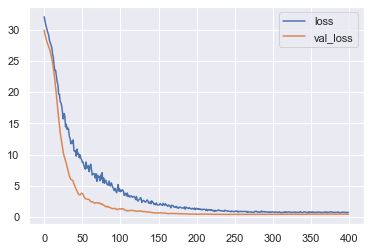

In [430]:
pd.DataFrame(history.history).plot()

In [431]:
mse = model.evaluate(X_test, y_test, verbose=0)
np.sqrt(mse)

0.6822053597489383

In [432]:
dnn_prediction = model.predict(X_test)

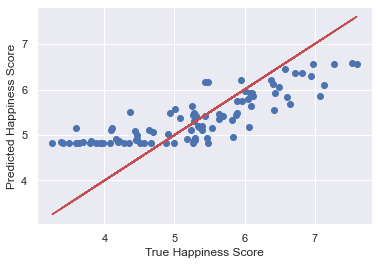

In [433]:
plt.xlabel('True Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.scatter(y_test, dnn_prediction)
plt.plot(y_test, y_test, c='r');

In The Last...

in conculsion, simple multivariable linear regressor was performing and generalized well as estimator of Happiness Score. This conclusion leads to answer of what factor will be leading to more higher Happiness score for each individual countries. If GDP per capita is growing exponetially some of factors such as Freedom, Life Expectancy, etc.. are growing as well. Also those factors have a positive correlation with Happiness Score in general. Thus GDP per capita growth tends to lead more Happiness Score theoretically. 